<a href="https://colab.research.google.com/github/78furu/deeplea_adv/blob/master/deeplea_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/github_repos/deeplea_adv/'
%pwd
! git pull

import unet

Mounted at /content/drive
/content/drive/MyDrive/github_repos/deeplea_adv
Already up to date.


In [2]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from preproc import training_and_eval, load_and_preprocess_data
import models
import yaml
from collections import namedtuple

print(f"Pytorch version: {torch.__version__}")

# Set the runtime environment to GPU in: Edit -> Notebook settings or Runtime -> Change runtime type  
if torch.cuda.is_available() is False:
    raise Exception("GPU device not found, runtime environment should be set to GPU")
print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Seed random number generator
torch.manual_seed(0)
np.random.seed(0)

Pytorch version: 1.8.0+cu101
Using GPU device: Tesla T4


In [3]:
config = yaml.load(open(r'scorenet.yml'))
config2 = {}
for k,d in config.items():
    MyTuple = namedtuple("MyTuple", d)
    my_tuple = MyTuple(**d)
    config2[k] = my_tuple

MyTuple = namedtuple("MyTuple", config2)
my_tuple = MyTuple(**config2)

In [4]:
import torch.nn as nn
import functools
import torch


class Score(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        nef = config.model.nef
        self.u_net = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(config.data.channels, nef, 4, stride=2, padding=1),
            # nn.Softplus(),
            nn.GroupNorm(4, nef),
            nn.ELU(),
            # state size. (nef) x 14 x 14
            nn.Conv2d(nef, nef * 2, 4, stride=2, padding=1),
            nn.GroupNorm(4, nef * 2),
            # nn.Softplus(),
            nn.ELU(),
            # state size. (nef*2) x 7 x 7
            nn.Conv2d(nef * 2, nef * 4, 5, stride=1, padding=0),
            nn.GroupNorm(4, nef * 4),
            # nn.Softplus(),
            nn.ELU(),
            # state size. (nef*4) x 3 x 3
            nn.ConvTranspose2d(nef * 4, nef * 2, 5, stride=1, padding=0),
            nn.GroupNorm(4, nef * 2),
            # nn.Softplus(),
            nn.ELU(),
            # state size. (nef*2) x 7 x 7
            nn.ConvTranspose2d(nef * 2, nef, 4, stride=2, padding=1),
            nn.GroupNorm(4, nef),
            # nn.Softplus(),
            nn.ELU(),
            # state size. (nef) x 14 x 14
            nn.ConvTranspose2d(nef, config.data.channels, 4, stride=2, padding=1),
            # nn.Softplus()
            nn.ELU()
            # state size. (nc) x 28 x 28
        )
        self.fc = nn.Sequential(
            nn.Linear(config.data.channels * config.data.image_size * config.data.image_size, 1024),
            nn.LayerNorm(1024),
            nn.ELU(),
            nn.Linear(1024, config.data.channels * config.data.image_size * config.data.image_size)
        )

        #self.layers = [l for l in self.u_net] + [l for l in self.fc]

    def forward(self, x):
        if x.is_cuda and self.config.training.ngpu > 1:
            score = nn.parallel.data_parallel(
                self.u_net, x, list(range(self.config.training.ngpu)))
        else:
            score = self.u_net(x)
        score = self.fc(score.view(x.shape[0], -1)).view(
            x.shape[0], self.config.data.channels, self.config.data.image_size, self.config.data.image_size)
        return score

In [5]:
net = Score(my_tuple)
MODEL = net.to(torch.cuda.current_device())
MODEL.input_size=(my_tuple.data.channels,32,32)

In [6]:
my_tuple

MyTuple(training=MyTuple(batch_size=128, n_epochs=500000, n_iters=50001, ngpu=1, noise_std=0.01, algo='ssm', snapshot_freq=5000), data=MyTuple(dataset='CIFAR10', image_size=32, channels=3, logit_transform=False), model=MyTuple(n_particles=1, lam=10, z_dim=100, nef=32, ndf=32), optim=MyTuple(weight_decay=0.0, optimizer='Adam', lr=0.001, beta1=0.9))

Files already downloaded and verified
Files already downloaded and verified
Dataset: cifar10 
 Image shape: (3, 32, 32) 
 Number of train images: 50000 
 Number of test images: 10000 
 Number of classes: 10 



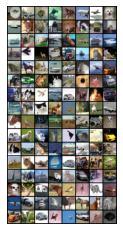

Model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           1,568
         GroupNorm-2           [-1, 32, 16, 16]              64
               ELU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          32,832
         GroupNorm-5             [-1, 64, 8, 8]             128
               ELU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]         204,928
         GroupNorm-8            [-1, 128, 4, 4]             256
               ELU-9            [-1, 128, 4, 4]               0
  ConvTranspose2d-10             [-1, 64, 8, 8]         204,864
        GroupNorm-11             [-1, 64, 8, 8]             128
              ELU-12             [-1, 64, 8, 8]               0
  ConvTranspose2d-13           [-1, 32, 16, 16]          32,800
        GroupNorm-14     

In [7]:

DATASET_NAME = 'cifar10'

# TODO
OPTIMIZER =  torch.optim.Adam(MODEL.parameters(), lr=1e-5)  
BATCH_SIZE = 128  
NUM_EPOCHS = 20 

trained_model, loss_and_accuracy_history = training_and_eval(DATASET_NAME, 
                                                             MODEL,
                                                             OPTIMIZER,
                                                             BATCH_SIZE, 
                                                             NUM_EPOCHS,
                                                             augment = False, 
                                                             need_summary = True)

In [8]:

128*32*32

131072

Files already downloaded and verified
Files already downloaded and verified
Dataset: cifar10 
 Image shape: (3, 32, 32) 
 Number of train images: 50000 
 Number of test images: 10000 
 Number of classes: 10 



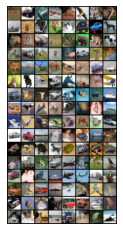

In [9]:
train, test = load_and_preprocess_data("cifar10", BATCH_SIZE)

In [10]:
outp = MODEL(torch.from_numpy((train.dataset.data[:32]/255).astype(np.float32)).permute([0, -1, 1,2]).to("cuda"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


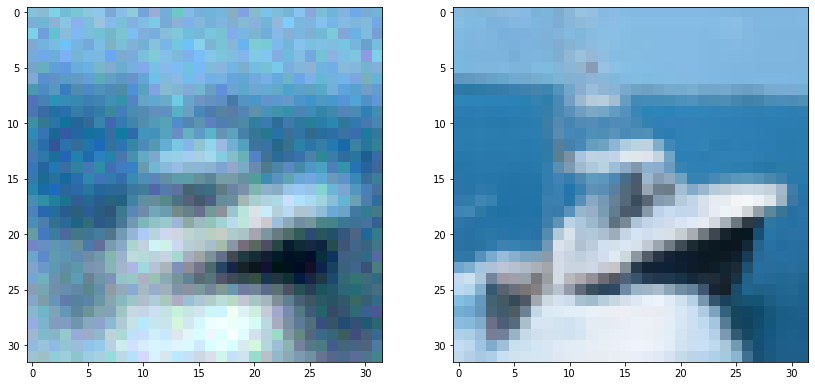

In [18]:
c = 8
image = outp[c].detach().cpu().numpy().astype(float)

fig, axes = plt.subplots(1,2, figsize=(14, 8))

ax = axes[0]
ax.imshow(np.moveaxis(image, [0,1,2], [2,0,1]))
ax = axes[1]
ax.imshow(train.dataset.data[c])

In [19]:
length = 10
ratio = pow(0.01/10, 1/9)
start = 10
progression = np.array([start * ratio**i for i in range(length)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

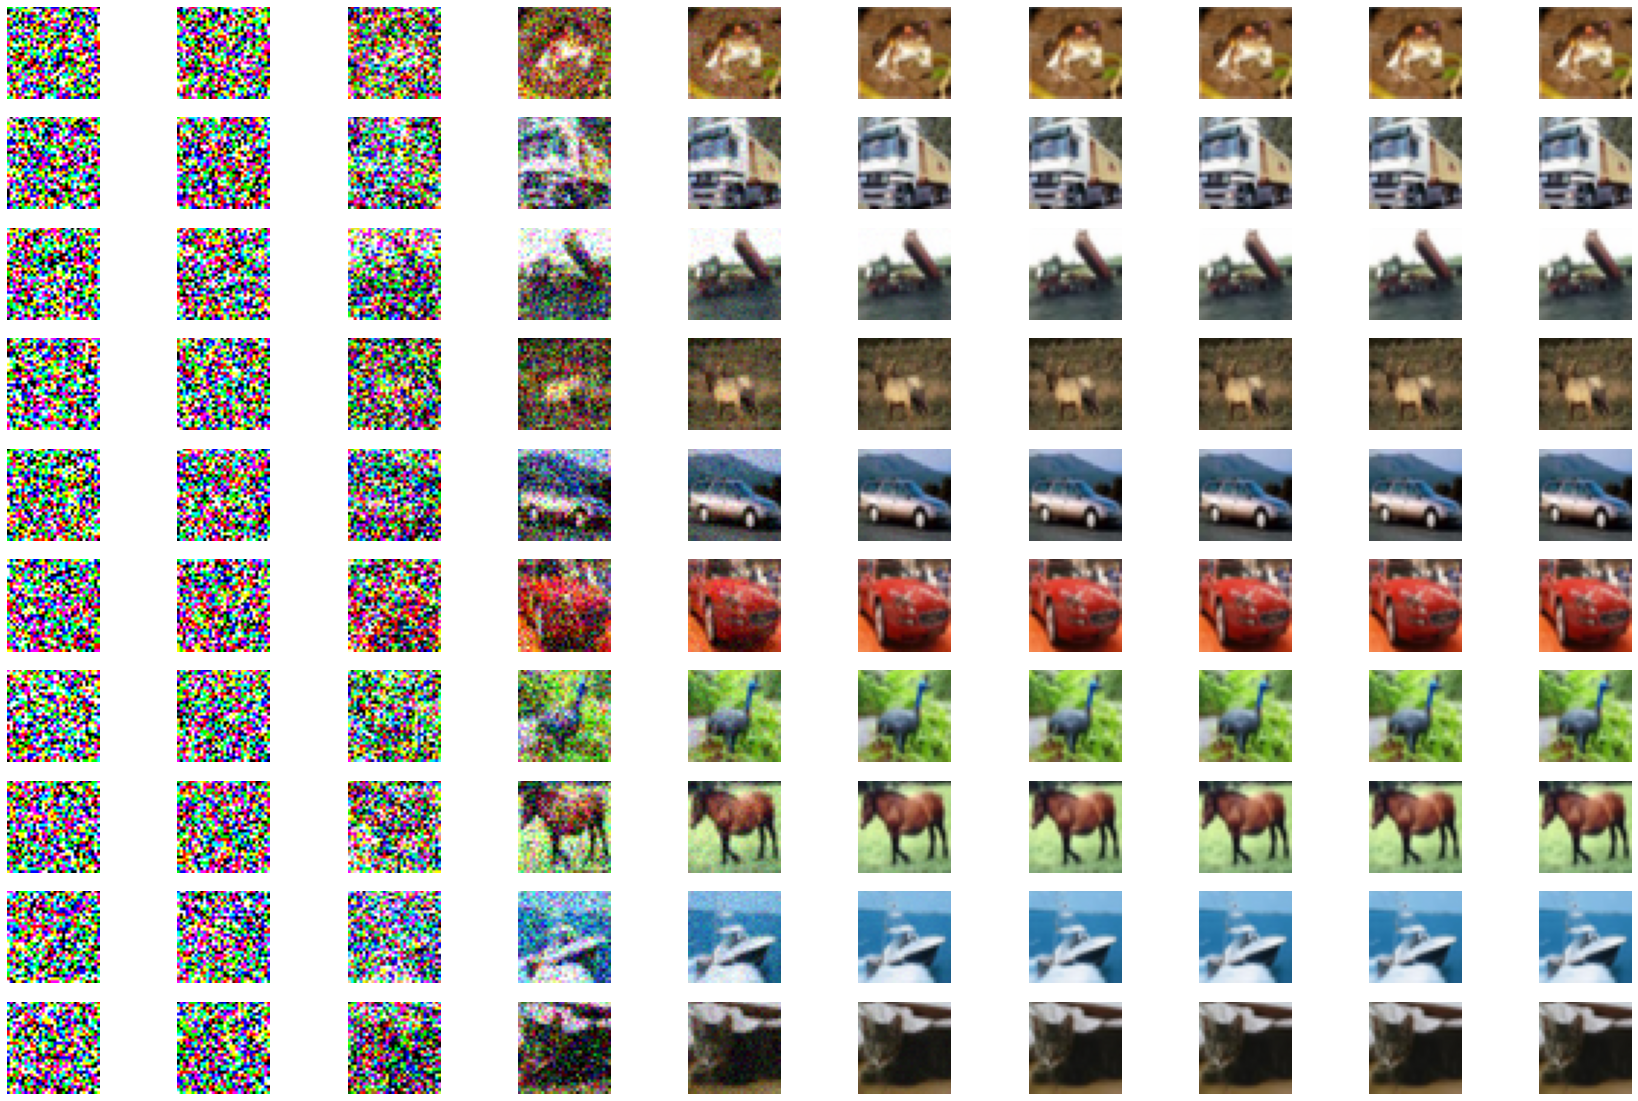

In [32]:
num_of_images = 10
epses = np.logspace(-5, -1, 9)

fig, axes = plt.subplots(num_of_images,progression.shape[0], figsize=(30, 20))
for im,c in zip(train.dataset.data, range(num_of_images)):
    for eps, ax in zip(progression, axes[c, :]):
        eps = (eps**2/progression[-1]**2)*2e-5
        im_ = im/255 + np.random.normal(scale=eps,size=im.shape)
        #im_ = (im_-np.min(im_))/(np.max(im_)-np.min(im_))
        ax.imshow(im_);
        ax.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

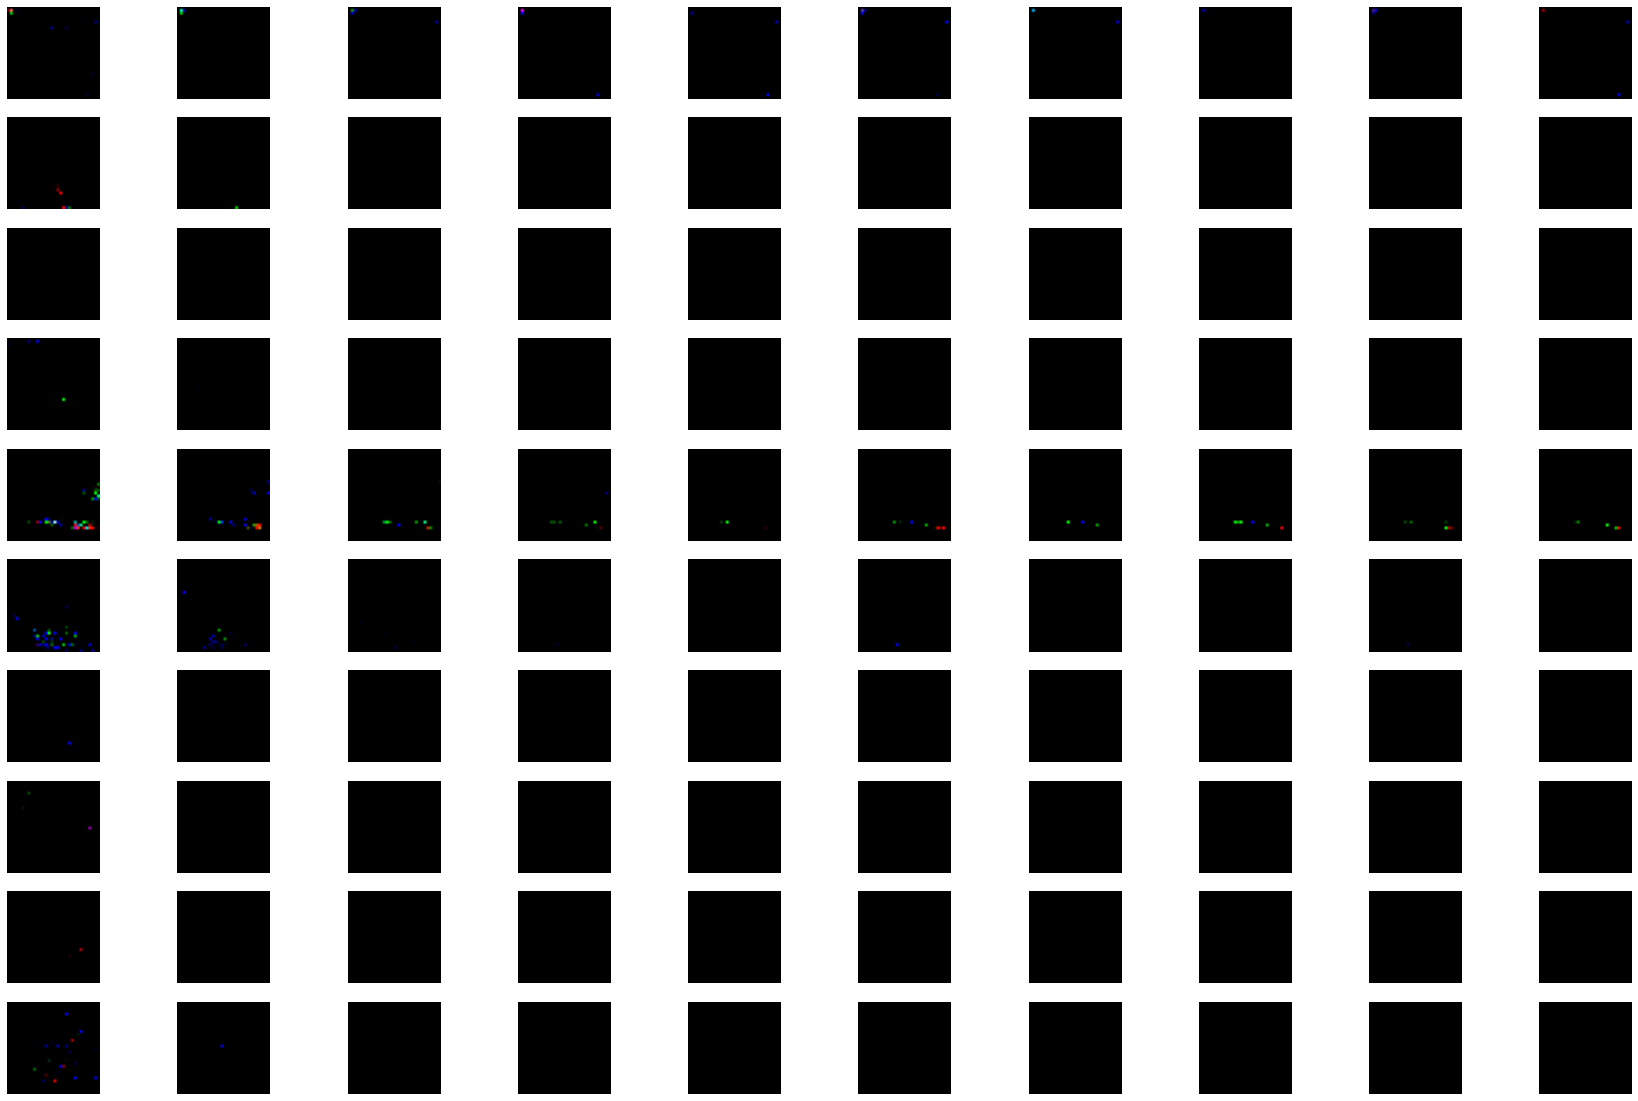

In [31]:
fig, axes = plt.subplots(num_of_images,progression.shape[0], figsize=(30, 20))
for im,c in zip(train.dataset.data, range(num_of_images)):
    for eps, ax in zip(progression, axes[c, :]):
        eps_ = (eps**2/progression[-1]**2)*2e-5
        im_ = im/255 + np.random.normal(scale=eps,size=im.shape)
        #im_ = (im_-np.min(im_))/(np.max(im_)-np.min(im_))
        ax.imshow((im_-im)/eps);
        ax.axis('off')

In [37]:
device = torch.cuda.current_device()
for sigma in epses:

    for i, (images, labels) in enumerate(train):
        images_o = images.to(device)
        #eps_ = (eps**2/progression[-1]**2)*2e-5
        images = images_o + torch.normal(std=sigma,size=images.shape)
        labels = (images-images_o)/sigma

TypeError: ignored

In [41]:
! git config --global user.name "Kristof Furuglyas"

In [43]:
! git push

Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 3.76 KiB | 1.25 MiB/s, done.
Total 6 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/78furu/deeplea_adv.git
   f83f938..cce1249  master -> master
